## hammurabiX tutorial e03

### random magnetic field visualization and spatial scaling verification

In this verification, we first want to visualize a small volume random magnetic field realization,
and then verify if the spatial scaling profile is correct.

In [1]:
#NBVAL_CHECK_OUTPUT

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import healpy as hp
import sys
import hampyx as hpx
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

- auxiliary functions for visualizing 3D magnetic field output from hammurabiX

(contributed by Tess R. Jaffe)

In [2]:
#NBVAL_CHECK_OUTPUT

def read_box(infile, inshape, dtype='double'):
    """
    Read in a binary dump from hammurabiX
    in either float or double format and convert to a numpy array of the given shape
    :param infile: input binary file path
    :param inshape: input field grid shape, i.e. [nx,ny,nz,3] for 3D grid
    :param dtype: input data type
    :return: a shaped array of field information from the given binary input
    """
    assert isinstance(infile, str)
    assert isinstance(inshape, (list,tuple))
    assert (len(inshape) == 4 and inshape[3] == 3)
    with open(infile, 'rb') as f:
        #  C floats of 4 bytes aren't python floats which are really
        #  doubles at 8 bytes.  So spcify f4.
        if dtype == 'float':
            data = np.frombuffer(f.read(), dtype='<f4')
        elif dtype == 'double':
            data = np.frombuffer(f.read(), dtype='<f8')
        else:
            raise TypeError('unsupported type %s' % str(dtype))
    return np.reshape(data, inshape)

def vis2d(infile, inshape, dtype='double', proj_axis=2, bins=100, tag=""):
    """
    2D (hsitogram) visualization of the binary field dump from hammurabiX
    :param infile:
    :param inshape:
    :param dtype:
    :param proj_axis: projection axis, allowing only 0,1,2
    :param bins: number of bins in 2D plot
    :param tag: the plotting legend
    :return: a projected 2D plot of magnetic field in micro Gauss
    """
    data = read_box(infile, inshape, dtype)
    nx = inshape[0]
    ny = inshape[1]
    nz = inshape[2]
    
    assert isinstance(proj_axis, int)
    assert (proj_axis in [0,1,2])
    
    mG = 1.e-6  # CGS_unit, micro Gauss
    xsample = np.reshape(data[:, :, :, proj_axis%3], (nx*ny*nz))/mG
    ysample = np.reshape(data[:, :, :, (proj_axis+1)%3], (nx*ny*nz))/mG
    
    x_std = np.std(xsample)
    y_std = np.std(ysample)
    m_std = np.sqrt((x_std**2+y_std**2)/2.0)
    
    h, xedges, yedges = np.histogram2d(xsample, ysample, bins=bins)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1, bins))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((bins, 1))
    x, y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    pdf = (h*(x_bin_sizes*y_bin_sizes))
    z = pdf.T
    levels = np.linspace(0, max(z.reshape(np.size(z))), 10)
    f2d, ax2d = plt.subplots(figsize=(5,5))
    ax2d.plot((0,0),(-3,3),'k:')
    ax2d.plot((-3,3),(0,0),'k:')
    cs = ax2d.contourf(x/m_std, y/m_std, z, cmap=cm.Blues, levels=levels)
    ax2d.set_xlim((-2, 2))
    ax2d.set_ylim((-2, 2))
    from matplotlib.ticker import FormatStrFormatter
    ax2d.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax2d.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax2d.tick_params(axis='both', which='major', labelsize='19')
    #ax2d.set_xlabel(r'$\sqrt{2}b_x/\sqrt{\sigma^2_x+\sigma^2_y}$', fontsize=19)
    #ax2d.set_ylabel(r'$\sqrt{2}b_y/\sqrt{\sigma^2_x+\sigma^2_y}$', fontsize=20)
    xlimits, ylimits = ax2d.get_xlim(), ax2d.get_ylim()
    aspect = (xlimits[1] - xlimits[0]) / (ylimits[1] - ylimits[0])
    ax2d.set_aspect(aspect)
    proxy = [plt.Rectangle((0, 0), 1, 1, fc=pc.get_facecolor()[0]) for pc in cs.collections]
    #ax2d.legend(proxy, [tag], fontsize=20, handletextpad=0.0, handlelength=0)
    #f2d.savefig(''.join((type, '2d_dist.pdf')))    

- define a hammurabi routine that produces a global magnetic field binary output

In [3]:
#NBVAL_CHECK_OUTPUT

def simulator(anisotropy, nx, ny, nz, n2l):
    """
    hammurabi X simulation setting
    :param anisotropy: level of anisotropy
    :param nx: grid size in x,y,z direction
    :param ny:
    :param nz:
    :param n2l: grid points per unit length (kpc)
    :return:
    """
    sim = hpx.Hampyx(xml_path='../templates/params_template.xml')
    sim.del_par(['obsio', 'sync'], True)
    sim.del_par(['obsio', 'dm'], True)
    sim.del_par(['obsio', 'faraday'], True)
    
    sim.mod_par(['grid', 'bfield', 'nx'], {'value': str(nx)})
    sim.mod_par(['grid', 'bfield', 'ny'], {'value': str(ny)})
    sim.mod_par(['grid', 'bfield', 'nz'], {'value': str(nz)})
    sim.mod_par(['grid', 'bfield', 'x_min'], {'value': str(-2.0*nx/n2l)})
    sim.mod_par(['grid', 'bfield', 'x_max'], {'value': str(2.0*nx/n2l)})
    sim.mod_par(['grid', 'bfield', 'y_min'], {'value': str(-2.0*ny/n2l)})
    sim.mod_par(['grid', 'bfield', 'y_max'], {'value': str(2.0*ny/n2l)})
    sim.mod_par(['grid', 'bfield', 'z_min'], {'value': str(-2.0*nz/n2l)})
    sim.mod_par(['grid', 'bfield', 'z_max'], {'value': str(2.0*nz/n2l)})
    
    sim.mod_par(['fieldio', 'bfield'], {'read': str(0), 'write': str(1), 'filename': 'brnd_global.bin'})
    # use 'test' regular B field setting
    sim.del_par(['bmodel'], True)
    sim.add_par([],'bmodel')
    sim.add_par(['bmodel'], 'unif', {'cue': str(1)})
    sim.add_par(['bmodel', 'unif'], 'bp', {'value': str(0.001)})
    # set field along x direction
    sim.add_par(['bmodel', 'unif'], 'l0', {'value': str(0.)})
    sim.add_par(['bmodel', 'unif'], 'bv', {'value': str(0.)})
    # choose turublent/random field type
    sim.add_par(['bmodel'], 'es', {'cue': str(1), 'seed': str(0)})
    sim.add_par(['bmodel', 'es'], 'rms', {'value': str(1.)})
    sim.add_par(['bmodel', 'es'], 'k0', {'value': str(0.5)})
    sim.add_par(['bmodel', 'es'], 'k1', {'value': str(0.1)})
    sim.add_par(['bmodel', 'es'], 'a0', {'value': str(1.7)})
    sim.add_par(['bmodel', 'es'], 'a1', {'value': str(0.0)})
    sim.add_par(['bmodel', 'es'], 'rho', {'value': str(anisotropy)})
    sim.add_par(['bmodel', 'es'], 'r0', {'value': str(nx/n2l)})
    sim.add_par(['bmodel', 'es'], 'z0', {'value': str(nz/n2l)})

    # no spatial scaling profile applied to the local MHD case

    sim()

- visualize

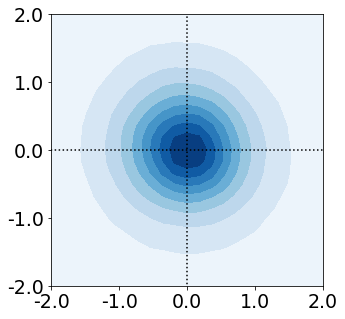

In [4]:
rho = 1.0
nx = 200
ny = 200
nz = 200
n2l = 50

simulator(rho, nx, ny, nz, n2l)

vis2d('brnd_global.bin',[nx,ny,nz,3])

- scaling check

In [5]:
#NBVAL_CHECK_OUTPUT

data = read_box('brnd_global.bin',[nx,ny,nz,3])

def b_of_z(iz):
    assert isinstance(iz, int)
    nx = np.shape(data)[0]
    ny = np.shape(data)[1]
    nz = np.shape(data)[2]
    assert (iz <= nz)
    slice_z = []
    mG = 1.e-6  # CGS_unit, micro Gauss
    for i in range(nx):
        for j in range(ny):
            bx = data[i,j,iz,0]/mG
            by = data[i,j,iz,1]/mG
            bz = data[i,j,iz,2]/mG
            slice_z.append(np.sqrt(bx**2+by**2+bz**2))
    return np.mean(slice_z),np.std(slice_z)

pick = range(0,nz,1)
b = np.zeros((len(pick),2))
for i in range(len(pick)):
    b[i] = b_of_z(pick[i])

- check the z direction scaling conceptually

(the scaling profile is described in [ApJS(2020),247,18](https://iopscience.iop.org/article/10.3847/1538-4365/ab72a2))

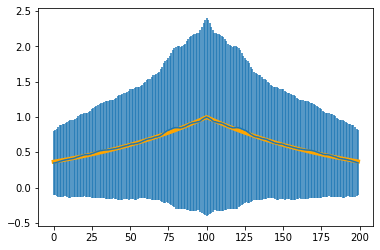

In [6]:
fig,ax = plt.subplots()
ax.errorbar(pick,b[:,0]/b[nz//2,0],yerr=b[:,1])

y = np.zeros(len(pick))
for i in range(len(y)):
    # the z direction scaling profile
    y[i] = np.sqrt(np.exp(-np.fabs(pick[i]-nz/2)/(nz/4)))
ax.plot(pick,y,'orange',linewidth=4)

clean up

In [7]:
import os
if os.path.isfile('err.log'):
    os.remove('err.log')
if os.path.isfile('run.log'):
    os.remove('run.log')
if os.path.isfile('brnd_global.bin'):
    os.remove('brnd_global.bin')

end